In [1]:
from netCDF4 import Dataset
import cartopy
import xarray
#import geoviews
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as cm
import matplotlib.ticker as mticker
import os
import nctoolkit as nct
import regex
from matplotlib.ticker import FormatStrFormatter
from cartopy.util import add_cyclic_point
from matplotlib import colors
import geopandas as gpd
import shapely.geometry as shp
#from osgeo import gdal,osr,ogr
import rioxarray
import pyproj
import pandas as pd

nctoolkit is using Climate Data Operators version 1.9.8


In [2]:
nct.deep_clean()

In [3]:
os.chdir('/media/jasmine/Album/Project')
print(os.getcwd())

/media/jasmine/Album/Project


In [4]:
# Load multiple files at once and getting variable names

files = ['Data/Raw/intpp_Omon_CESM2_esm-ssp585_r1i1p1f1_gn_201501-206412.nc',
         'Data/Raw/intpp_Omon_CESM2_esm-ssp585_r1i1p1f1_gn_206501-210012.nc']

names = ', '.join(files)
print(names)

variable = regex.search(r"(?<=Data/Raw/)[^_]*", names).group()
print(variable)
model = regex.search(r"(?<=Data/Raw/.*?_.*?_)[^_]*", names).group()
print(model)
experiment = "esm-ssp585"
#experiment = regex.search(r"(?<=Data/Raw/.*?_.*?_.*?_)[^_]*", names).group()
print(experiment)

start = 2015
end = 2100

Data/Raw/intpp_Omon_CESM2_esm-ssp585_r1i1p1f1_gn_201501-206412.nc, Data/Raw/intpp_Omon_CESM2_esm-ssp585_r1i1p1f1_gn_206501-210012.nc
intpp
CESM2
esm-ssp585


In [3]:
nc = nct.open_data(files)
print(nc.variables)

nc.merge("time")
nc.to_latlon(lon = [-180, 180], lat = [-90, 90], res = [1,1])
nc.to_nc("Data/{}_{}_{}.nc".format(variable, model, experiment), overwrite = True)

['intpp']


In [8]:
nc = nct.open_data("Data/{}_{}_{}.nc".format(variable, model, experiment))
nc.tmean("year")
nc.to_nc("Data/{}_{}_{}_year.nc".format(variable, model, experiment), overwrite = True)

## Sea fronts


In [13]:
fp = "Shapes/SO_fronts_Park.shp"
shape = gpd.read_file(fp)

In [14]:
print(type(shape))

print(shape)

<class 'geopandas.geodataframe.GeoDataFrame'>
                                     name  front  \
0                       Northern Boundary     NB   
1                            Subantarctic    SAF   
2                                   Polar     PF   
3  Southern Antarctic Circumpolar Current  SACCF   
4                       Southern Boundary     SB   

                                            geometry  
0  LINESTRING (-179.93750 -45.81014, -179.93359 -...  
1  LINESTRING (-179.93750 -56.08626, -179.81250 -...  
2  LINESTRING (-179.94189 -60.06250, -179.93750 -...  
3  LINESTRING (-179.93750 -63.74692, -179.81250 -...  
4  LINESTRING (-179.93750 -64.41047, -179.86058 -...  


<AxesSubplot:>

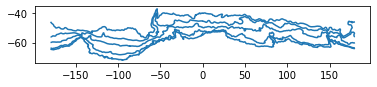

In [15]:
shape.plot()

In [9]:
shape.crs

<Geographic 2D CRS: GEOGCS["GCS_WGS_84_with_axis_order_normalized_for_ ...>
Name: GCS_WGS_84_with_axis_order_normalized_for_visualization
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

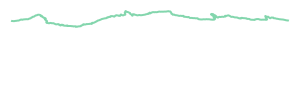

In [10]:
shape['geometry'][4]

In [10]:
project = cartopy.crs.Orthographic(central_longitude = 0, 
                                                  central_latitude=-90)

project_proj4 = project.proj4_init


In [16]:
new = shape.to_crs("epsg:3031")
new.crs

<Derived Projected CRS: EPSG:3031>
Name: WGS 84 / Antarctic Polar Stereographic
Axis Info [cartesian]:
- E[north]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Antarctica.
- bounds: (-180.0, -90.0, 180.0, -60.0)
Coordinate Operation:
- name: Antarctic Polar Stereographic
- method: Polar Stereographic (variant B)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

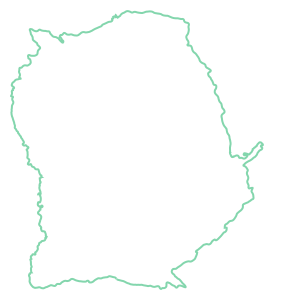

In [15]:
new['geometry'][4]

In [61]:
front = shp.LineString(new['geometry'][4])
print(front.coords[0][0])
x_coord = tuple(front.xy[0])
y_coord = tuple(front.xy[1])

print(x_coord[0:5])

-3082.311393992493
(-3082.311393992493, -6868.415410414154, -9227.117004249578, -15335.643296815231, -17962.562095470952)


In [62]:
poly = shp.Polygon([p[0], p[1]] for p in front.coords)


In [70]:
poly_new = gpd.GeoSeries(poly)

In [72]:
type(poly_new)

geopandas.geoseries.GeoSeries

In [17]:
outfp = "Shapes/SO_fronts_Park_new.shp"

newdata = gpd.GeoDataFrame()
newdata['geometry'] = None

newdata.loc['geometry'] = new['geometry']
newdata.loc['front'] = '{}'.format(shape['front'])
newdata.loc['name'] = '{}'.format(shape['name'])
newdata
#newdata.to_file(outfp)

,geometry
geometry,NaN
front,0 NB\n1 SAF\n2 PF\n3 SACCF...
name,0 Northern Boundary\n1...


In [19]:
# convert shp to nc
!gdal_rasterize -of netCDF -burn 1 -tr 0.01 0.01 Shapes/SO_fronts_Park_SB.shp Shapes/SO_fronts_Park_SB.nc

0...10...20...30...40...50...60...70...80...90...100 - done.


In [23]:
# regrid (regrid the new shape file to match the data file) 
!cdo remapbil,Data/intpp_CESM2_esm-ssp585.nc Shapes/SO_fronts_Park_SB.nc Shapes/SO_fronts_Park_SB.nc

cdo    remapbil: Bilinear weights from lonlat (35989x2023) to lonlat (361x181) grid
cdo    remapbil:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    remapbil: Processed 1 variable over 1 timestep [2.81s 1702MB].


In [24]:
# mask
!cdo ifthen Shapes/SO_fronts_Park_SB.nc Data/intpp_CESM2_esm-ssp585.nc Data/intpp_CESM2_esm-ssp585_SB.nc

cdo    ifthen: Filling up stream1 >Shapes/SO_fronts_Park_SB.nc< by copying the first timestep.
cdo    ifthen: Processed 2 variables over 1033 timesteps [5.49s 233MB].


In [40]:
nc = nct.open_data("Data/intpp_CESM2_esm-ssp585_SB.nc")
print(nc.variables)

nc.subset(year = 2020)
nc.tmean()

nc.to_nc("Data/intpp_CESM2_esm-ssp585_SB.nc", overwrite = True)



['intpp']


In [9]:
nc_og = xarray.open_dataset("Data/intpp_CESM2_esm-ssp585_year.nc")
nc_og

<xarray.Dataset>
Dimensions:    (time: 86, bnds: 2, lon: 361, lat: 181)
Coordinates:
  * time       (time) object 2015-06-30 06:00:00 ... 2100-06-30 06:00:00
  * lon        (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
  * lat        (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    intpp      (time, lat, lon) float32 ...
Attributes: (12/44)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Thu Jul 21 00:07:50 2022: cdo -L -z zip_9 -yearme...
    source:                 CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite v...
    institution:            National Center for Atmospheric Research
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            C4MIP
    ...                     ...
    table_id:               Omon
    tracking_id:            hdl:21.14100/21264bf7-65d3-4617-bc65-c160b054efe5
    variable_id:            intpp
    variant_info:           CMIP6 esm-ssp585 experiments (2015-2100) with CAM...
    variant_label:          r1i1p1f1
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [10]:
nc = nc_og.drop_vars("time_bnds")
nc

<xarray.Dataset>
Dimensions:  (time: 86, lon: 361, lat: 181)
Coordinates:
  * time     (time) object 2015-06-30 06:00:00 ... 2100-06-30 06:00:00
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
Data variables:
    intpp    (time, lat, lon) float32 ...
Attributes: (12/44)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Thu Jul 21 00:07:50 2022: cdo -L -z zip_9 -yearme...
    source:                 CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite v...
    institution:            National Center for Atmospheric Research
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            C4MIP
    ...                     ...
    table_id:               Omon
    tracking_id:            hdl:21.14100/21264bf7-65d3-4617-bc65-c160b054efe5
    variable_id:            intpp
    variant_info:           CMIP6 esm-ssp585 experiments (2015-2100) with CAM...
    variant_label:          r1i1p1f1
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [11]:
nc.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
nc.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset>
Dimensions:      (time: 86, lon: 361, lat: 181)
Coordinates:
  * time         (time) object 2015-06-30 06:00:00 ... 2100-06-30 06:00:00
  * lon          (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
  * lat          (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
    spatial_ref  int64 0
Data variables:
    intpp        (time, lat, lon) float32 ...
Attributes: (12/44)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Thu Jul 21 00:07:50 2022: cdo -L -z zip_9 -yearme...
    source:                 CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite v...
    institution:            National Center for Atmospheric Research
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            C4MIP
    ...                     ...
    table_id:               Omon
    tracking_id:            hdl:21.14100/21264bf7-65d3-4617-bc65-c160b054efe5
    variable_id:            intpp
    variant_info:           CMIP6 esm-ssp585 experiments (2015-2100) with CAM...
    variant_label:          r1i1p1f1
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [12]:
for _, r in new.iterrows():
    globals()[f"front{_}"] = r['front']
    print(globals()[f"front{_}"])
    
    globals()[f"name{_}"] = r['name']
    print(globals()[f"name{_}"])
    
    front = shp.LineString(r['geometry'])
    print(front.coords[0][0])
    x_coord = tuple(front.xy[0])
    y_coord = tuple(front.xy[1])
    print(x_coord[0:5])
    
    poly = shp.Polygon([p[0], p[1]] for p in front.coords)
    poly_new = gpd.GeoSeries(poly)
    
    clipped = nc.rio.clip(poly_new.geometry.values, 
                          crs = 3031, 
                          drop = False,
                          all_touched = True)
    
    path = "Data/{}_{}_{}_{}.nc".format(variable, model, experiment, r['front'])
    print(path)
    
    clipped.to_netcdf(path = path, mode = 'w', format = "NETCDF4")

    
    

NB
Northern Boundary
-5503.010237339075
(-5503.010237339075, -5846.603249966886, -16462.43588338524, -17747.252162187582, -27363.20594089297)
Data/intpp_CESM2_esm-ssp585_NB.nc
SAF
Subantarctic
-4136.380004799798
(-4136.380004799798, -12402.505845740967, -20663.11482342286, -28925.1159904472, -37189.40199693351)
Data/intpp_CESM2_esm-ssp585_SAF.nc
PF
Polar
-3373.3725164196744
(-3373.3725164196744, -3628.099203789208, -10892.914300102544, -18169.52483293729, -25458.20776378051)
Data/intpp_CESM2_esm-ssp585_PF.nc
SACCF
Southern Antarctic Circumpolar Current
-3164.9594909454445
(-3164.9594909454445, -9489.480104645254, -15804.401523944396, -22110.161536784773, -26084.62177521806)
Data/intpp_CESM2_esm-ssp585_SACCF.nc
SB
Southern Boundary
-3082.311393992493
(-3082.311393992493, -6868.415410414154, -9227.117004249578, -15335.643296815231, -17962.562095470952)
Data/intpp_CESM2_esm-ssp585_SB.nc


In [12]:
data = pd.DataFrame(index = time)
data

""
2015
2016
2017
2018
2019
...
2096
2097
2098
2099


In [10]:
    nc = nct.open_data("Data/{}_{}_{}_PF.nc".format(variable, model, experiment))
    
    time = nc.years
    time = list(time)
data = pd.DataFrame({

   'pig': [],

   'horse': []

   }, index=time)
data

ValueError: Length of values (0) does not match length of index (86)

In [19]:

    
    nc = xarray.open_dataset("Data/{}_{}_{}_PF.nc".format(variable, model, experiment))
    nc = nc.drop_vars("spatial_ref")
    nc = nc.groupby("time").mean(["lat", "lon"])
             
    var = nc.variables[variable][:]
    var = list(var.values)

    front = "PF"
    data[front] = var 

In [20]:
data

,PF
2015,1.431383e-07
2016,1.509460e-07
2017,1.412782e-07
2018,1.520557e-07
2019,1.407505e-07
...,...
2096,1.656838e-07
2097,1.890034e-07
2098,1.681883e-07
2099,1.701810e-07


In [23]:
for _, r in new.iterrows():
    
    nc = xarray.open_dataset("Data/{}_{}_{}_{}.nc".format(variable, model, experiment, r['front']))
    nc = nc.drop_vars("spatial_ref")
    nc = nc.groupby("time").mean(["lat", "lon"])
             
    var = nc.variables[variable][:]
    var = list(var.values)
    
    front = r['front']
    print(front)
                 
    data[front] = var

NB
SAF
PF
SACCF
SB


In [24]:
data

,PF,NB,SAF,SACCF,SB
2015,1.431383e-07,1.817103e-07,1.589198e-07,1.289384e-07,1.226912e-07
2016,1.509460e-07,1.840550e-07,1.638355e-07,1.397385e-07,1.347447e-07
2017,1.412782e-07,1.786355e-07,1.561268e-07,1.284250e-07,1.231823e-07
2018,1.520557e-07,1.854861e-07,1.653703e-07,1.383194e-07,1.306310e-07
2019,1.407505e-07,1.755496e-07,1.545501e-07,1.286825e-07,1.238091e-07
...,...,...,...,...,...
2096,1.656838e-07,2.002464e-07,1.799680e-07,1.621329e-07,1.610276e-07
2097,1.890034e-07,2.191501e-07,2.004212e-07,1.829671e-07,1.806307e-07
2098,1.681883e-07,2.039089e-07,1.820199e-07,1.622302e-07,1.604661e-07
2099,1.701810e-07,2.075224e-07,1.853915e-07,1.647472e-07,1.630746e-07


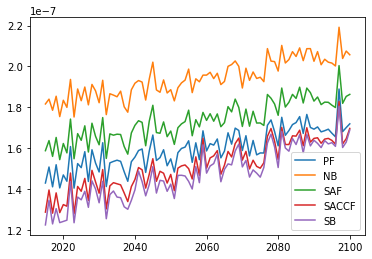

In [29]:
fig = data.plot.line()
plot = fig.get_figure()
plot.savefig("output/{}_{}_{}_seafronts.png".format(variable, model, experiment))

TypeError: unhashable type: 'list'

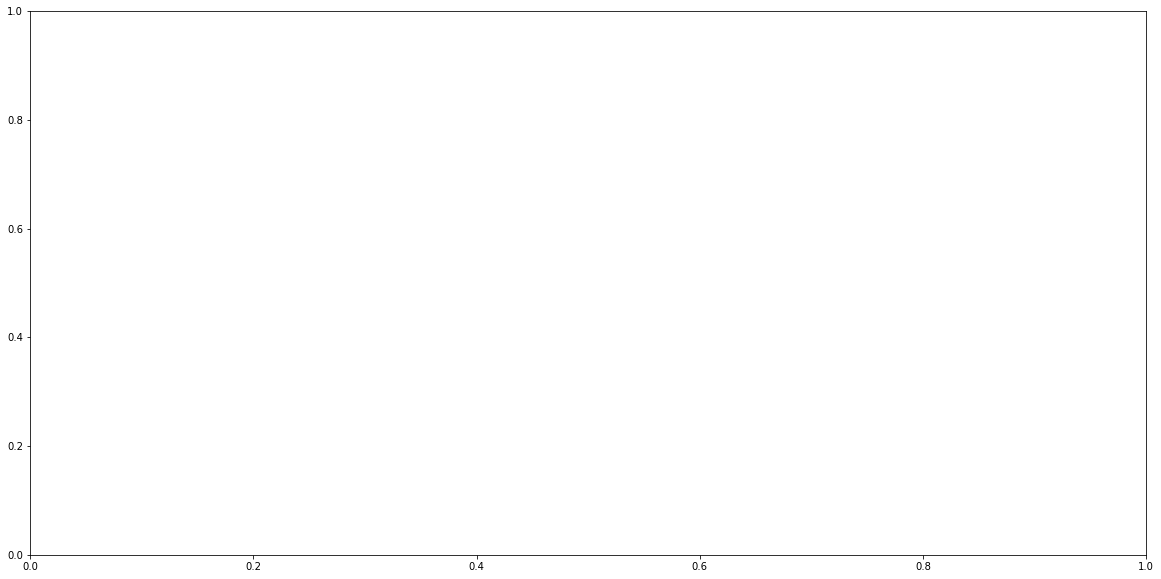

In [ ]:
fig = plt.figure(figsize=[20, 10])

ax = fig.add_subplot(1,1,1)

#ax.plot(data['time'], data['var'], data['front'])

ax.title.set_text("{}".format(model))

ax.set_xlabel('xlabel', fontdict=dict(weight='bold'))
ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("NPP (mol m-2 s-1)")
plt.xlabel("Year")

#plt.savefig("output/{}_{}_{}_projection.png".format(variable, model, experiment))

plt.show()

In [65]:
Africa_Shape = gpd.read_file("Shapes/SO_fronts_Park_SB.shp", 
                             crs = "epsg:3031")

Africa_Shape = Africa_Shape['geometry']

In [67]:
Africa_Shape

0    POLYGON ((-3082.311 -2825653.824, -6868.415 -2...
Name: geometry, dtype: geometry

In [66]:
type(Africa_Shape)

geopandas.geoseries.GeoSeries

In [ ]:

clipped = nc.rio.clip(poly_new.geometry.values, crs = 3031, drop = False,all_touched = True)

In [4]:
# function to create the mask of your shapefile
# function to create the mask of your shapefile
def makeMask(lon,lat,res):
    source_ds = ogr.Open(shapefile)
    source_layer = source_ds.GetLayer()
 
    # Create high res raster in memory
    mem_ds = gdal.GetDriverByName('MEM').Create('', lon.size, lat.size, gdal.GDT_Byte)
    mem_ds.SetGeoTransform((lon.min(), res, 0, lat.max(), 0, -res))
    band = mem_ds.GetRasterBand(1)
 
    # Rasterize shapefile to grid
    gdal.RasterizeLayer(mem_ds, [1], source_layer, burn_values=[1])
 
    # Get rasterized shapefile as numpy array
    array = band.ReadAsArray()
 
    # Flush memory file
    mem_ds = None
    band = None
    return array

In [9]:
# read the netcdf data file
shapefile = "Shapes/SO_fronts_Park_SB.shp"
nc = Dataset("Data/intpp_CESM2_esm-ssp585.nc")
 
# get the precipitation
lat = nc.variables['lat'][:] # [:] means all elements inside the list
lon = nc.variables['lon'][:]
var = nc.variables [variable][:]

# calculate the cellsize
cellsize = lon[:][1] - lon[:][0]
 

Warning 1: Failed to fetch spatial reference on layer SO_fronts_Park_SB to build transformer, assuming matching coordinate systems.


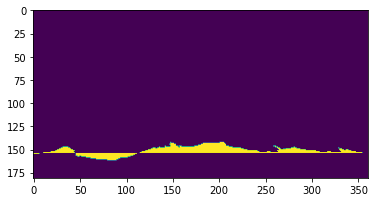

In [11]:
# create the mask
mask = makeMask(lon,lat,cellsize)
 
# show the mask
plt.imshow(mask)
plt.show()


In [12]:
 # mask the precipitation data
precip = np.ma.masked_where(mask==0,var)


IndexError: Inconsistent shape between the condition and the input (got (181, 361) and (1032, 181, 361))

In [36]:
lat = clipped.variables['lat'][:] # [:] means all elements inside the list
lon = clipped.variables['lon'][:]
var = clipped.variables [variable][1,:,:]

#mean_var = np.nanmean(var, axis = 0) 
print(var.shape) 

x, y = np.meshgrid(lon, lat)
print(x)

(181, 361)
[[-180. -179. -178. ...  178.  179.  180.]
 [-180. -179. -178. ...  178.  179.  180.]
 [-180. -179. -178. ...  178.  179.  180.]
 ...
 [-180. -179. -178. ...  178.  179.  180.]
 [-180. -179. -178. ...  178.  179.  180.]
 [-180. -179. -178. ...  178.  179.  180.]]


In [85]:
lat = nc_og.variables['lat'][:] # [:] means all elements inside the list
lon = nc_og.variables['lon'][:]
var = nc_og.variables [variable][1,:,:]

#mean_var = np.nanmean(var, axis = 0) 
print(var.shape) 

x, y = np.meshgrid(lon, lat)
print(x)

(181, 361)
[[-180. -179. -178. ...  178.  179.  180.]
 [-180. -179. -178. ...  178.  179.  180.]
 [-180. -179. -178. ...  178.  179.  180.]
 ...
 [-180. -179. -178. ...  178.  179.  180.]
 [-180. -179. -178. ...  178.  179.  180.]
 [-180. -179. -178. ...  178.  179.  180.]]


In [67]:
print(clipped)

<xarray.Dataset>
Dimensions:      (lat: 181, lon: 361, time: 1032)
Coordinates:
  * lat          (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon          (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
  * time         (time) object 2015-01-15 12:59:59.999997 ... 2100-12-15 12:0...
    spatial_ref  int64 0
Data variables:
    intpp        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/44)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Tue Jul 19 21:03:45 2022: cdo -L -z zip_9 copy /t...
    source:                 CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite v...
    institution:            National Center for Atmospheric Research
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            C4MIP
    ...                     ...
    table_id:               Omon
    tracking_id:            hdl:21.14100/21264bf7-65d3-4617-bc65-c160b054efe5
    var

/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning

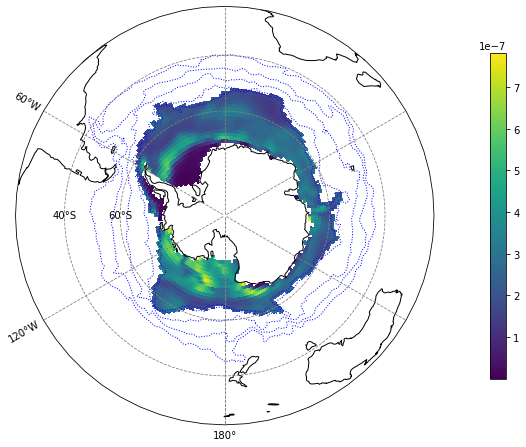

In [37]:
fig = plt.figure(figsize=[10, 10])

ax = fig.add_subplot(1,1,1,
                     projection = cartopy.crs.Orthographic(central_longitude = 0, 
                                                  central_latitude=-90))
#ax = plt.axes(projection=cartopy.crs.PlateCarree())

#plt.title("Change in NPP (mol m-2 s-1) {} 1994-2100".format(model, start),
 #        fontsize = 15)

#ax.add_feature(cartopy.feature.LAND)
#ax.add_feature(cartopy.feature.OCEAN)
#ax.add_feature(cartopy.feature.COASTLINE)



#divnorm = colors.TwoSlopeNorm(vmin = -label, vcenter = 0., vmax = label)

p = ax.pcolor(x, y, var, 
              transform = cartopy.crs.PlateCarree() )
#p = ax.pcolor(x, y, mean_var, 
 #             transform = project_proj4)
cb = plt.colorbar(p, shrink=0.6, pad = 0.1)



gl = ax.gridlines(crs = cartopy.crs.PlateCarree(),
                  draw_labels = True,
                  color = 'grey',
                  linestyle = '--',
                  y_inline = True) 

gl.ylabel_style = {'size': 10}
gl.xlabel_style = {'size': 10}

gl.ylocator = mticker.FixedLocator([-60, -40])

plt.draw()
for ea in gl.label_artists:
    if ea[0]== 'lat':
        tx = ea[2]
        xy = tx.get_position()
        if xy[0]!=-90:
            tx.set_position([-90, xy[1]])
            

            
ax.coastlines()


ax.add_geometries(shape['geometry'], 
                  cartopy.crs.PlateCarree(),
                  facecolor = 'none', 
                  edgecolor = 'blue',
                  linestyle = ':')



#ax.contour(x_coord, y_coord, z,
         #  levels=1,
          # colors=['black'],
          # transform = cartopy.crs.PlateCarree())

ax.set_global()         
            
#plt.savefig("output/{}_{}_{}_change.png".format(variable, model, experiment))

plt.show()

## Correlation


### Temporal correlation

In [18]:
npp = nct.open_data("Data/intpp_{}_{}.nc".format(model, experiment))

exp = nct.open_data("Data/epc100_{}_{}.nc".format(model, experiment))


In [13]:
npp.current

['Data/intpp_CESM2_esm-ssp585.nc']

In [19]:
cor = nct.cor_time(npp, exp)
#cor.reduce_dims()
cor.to_nc("Data/correlation_time.nc", overwrite = True)

In [20]:
nc = Dataset("Data/correlation_time.nc")
print(nc.variables)

lat = nc.variables['lat'][:] # [:] means all elements inside the list
lon = nc.variables['lon'][:]
print(len(lat), len(lon))

var = nc.variables ['cor'][:]

var = np.nanmean(var, axis = 0)
print(var.shape)
var_max = np.amax(var)
var_min = np.amin(var)
print(var_max, var_min)


var, lon = add_cyclic_point(var, coord=lon)

x, y = np.meshgrid(lon, lat)

{'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    bounds: time_bnds
    units: days since 0001-01-01 00:00:00
    calendar: 365_day
    axis: T
unlimited dimensions: time
current shape = (1,)
filling off, 'time_bnds': <class 'netCDF4._netCDF4.Variable'>
float64 time_bnds(time, bnds)
unlimited dimensions: time
current shape = (1, 2)
filling off, 'lon': <class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (361,)
filling off, 'lat': <class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    standard_name: latitude
    long_name: Latitude
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (181,)
filling off, 'cor': <class 'netCDF4._netCDF4.Variable'>
float32 cor(time, lat, lon)
    standard_name: net_primary_mole_productivity_of_biomass_expressed_as_carbon_by_phytoplankton
    long_name: Primary Org

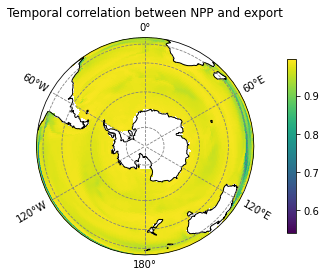

In [21]:
ax = plt.axes(projection=cartopy.crs.Orthographic(central_longitude = 0, 
                                                  central_latitude=-90))

plt.title("Temporal correlation between NPP and export")

#ax.add_feature(cartopy.feature.LAND)
#ax.add_feature(cartopy.feature.OCEAN)
#ax.add_feature(cartopy.feature.COASTLINE)

#divnorm = colors.TwoSlopeNorm(vmin = var_min, vcenter = 0., vmax = var_max)

p = ax.pcolor(x, y, var, 
              cmap = 'viridis', transform = cartopy.crs.PlateCarree() )

cb = plt.colorbar(p, shrink=0.8, pad = 0.1)

gl = ax.gridlines(crs = cartopy.crs.PlateCarree(),
                  draw_labels = True,
                  color = 'grey',
                  linestyle = '--') 

ax.coastlines()

plt.savefig("output/Temporal Correlation.png".format(variable, model, experiment))

plt.show()

### Spatial correlation


In [5]:
npp = nct.open_data("Data/intpp_{}_{}.nc".format(model, experiment))
exp = nct.open_data("Data/epc100_{}_{}.nc".format(model, experiment))

npp.crop(lon = [-180, 180], lat = [-90, -40])
exp.crop(lon = [-180, 180], lat = [-90, -40])

In [7]:
cor = nct.cor_space(npp, exp)

cor.to_nc("Data/correlation_space.nc", overwrite = True)

In [8]:
cor = nct.open_data("Data/correlation_space.nc")
cor.contents
cor.tmean("year")
time = cor.years

cor.to_nc("Data/correlation_over_time.nc", overwrite = True)

In [9]:
cor = nct.open_data("Data/correlation_over_time.nc")
time = cor.years

nc = Dataset("Data/correlation_over_time.nc")
print(nc.variables)

var = nc.variables ['cor'][:]

print(var)
var = np.nanmean(var, axis = 1)
var = np.nanmean(var, axis = 1)
print(var)
print(var.shape)

{'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    bounds: time_bnds
    units: days since 0001-01-01 00:00:00
    calendar: 365_day
    axis: T
unlimited dimensions: time
current shape = (86,)
filling off, 'time_bnds': <class 'netCDF4._netCDF4.Variable'>
float64 time_bnds(time, bnds)
unlimited dimensions: time
current shape = (86, 2)
filling off, 'lon': <class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    standard_name: longitude
    long_name: longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (1,)
filling off, 'lat': <class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    standard_name: latitude
    long_name: latitude
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (1,)
filling off, 'cor': <class 'netCDF4._netCDF4.Variable'>
float32 cor(time, lat, lon)
    standard_name: net_primary_mole_productivity_of_biomass_expressed_as_carbon_by_phytoplankton
    long_name: Primary Organ

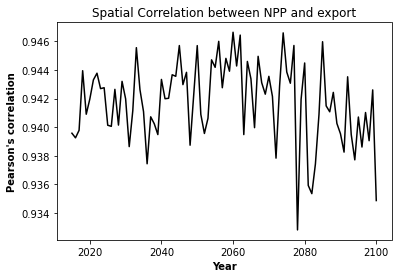

In [10]:
fig, ax = plt.subplots()

ax.plot(time, var, 'k')
ax.title.set_text("Spatial Correlation between NPP and export")

ax.set_xlabel('xlabel', fontdict=dict(weight='bold'))
ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Pearson's correlation")
plt.xlabel("Year")

plt.savefig("output/Correlation between NPP and export.png".format(variable, model, experiment))

plt.show()

## Difference


### Calculation


In [30]:
# historial experiment 

historical = nct.open_data("Data/Raw/intpp_Omon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc")
print(historical.contents)

historical.to_latlon(lon = [-180, 180], lat = [-90, 90], res = [1,1])
historical.subset(year = range(1994, 2014))

historical.tmean()



new = nct.open_data("Data/{}_{}_{}.nc".format(variable, model, experiment))
print(new.contents)

new.subset(year = range(2080, 2100))
new.tmean()



new.subtract(historical)

new.reduce_dims()
new.to_nc("Data/{}_{}_difference.nc".format(variable, model), overwrite = True)


/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'intpp' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'intpp' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.


  variable  ntimes  npoints  nlevels  \
0    intpp    1980   122880        1   

                                           long_name         unit data_type  
0  Primary Organic Carbon Production by All Types...  mol m-2 s-1      F32z  


/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'intpp' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.


  variable  ntimes  npoints  nlevels  \
0    intpp    1032    65341        1   

                                           long_name         unit data_type  
0  Primary Organic Carbon Production by All Types...  mol m-2 s-1      F32z  


/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/nctoolkit/add_etc.py:92: UserWarning: Use CDO>=1.9.10 for smarter operations


In [14]:
historical = nct.open_data("Data/Raw/intpp_Omon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc")
print(historical.contents)

historical.to_latlon(lon = [-180, 180], lat = [-90, 90], res = [1,1])
historical.subset(year = range(1994, 2014))

historical.tmean()

historical.to_nc("Data/{}_{}_historical_20y.nc".format(variable, model), overwrite = True)

/opt/jaspy/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'intpp' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
/opt/jaspy/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'intpp' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.


  variable  ntimes  npoints  nlevels  \
0    intpp    1980   122880        1   

                                           long_name         unit data_type  
0  Primary Organic Carbon Production by All Types...  mol m-2 s-1      F32z  


/opt/jaspy/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'intpp' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.


In [11]:
new = nct.open_data("Data/{}_{}_{}.nc".format(variable, model, experiment))
print(new.contents)

new.subset(year = range(2080, 2100))
new.tmean()

new.to_nc("Data/{}_{}_{}_20y.nc".format(variable, model, experiment), overwrite = True)

  variable  ntimes  npoints  nlevels  \
0    intpp    1032    65341        1   

                                           long_name         unit data_type  
0  Primary Organic Carbon Production by All Types...  mol m-2 s-1      F32z  


In [17]:
new = Dataset("Data/{}_{}_historical_20y.nc".format(variable, model, experiment))
print(new.variables)
var_new = new.variables [variable][:]
print(var_new)

new = Dataset("Data/{}_{}_{}_20y.nc".format(variable, model, experiment))
print(new.variables)
var_new = new.variables [variable][:]
print(var_new)

difference = Dataset("Data/{}_{}_difference.nc".format(variable, model), overwrite = True)
print(difference.variables)

var_dif = difference.variables [variable][:]
print(var_dif)
print(np.amax(var_dif), np.amin(var_dif))

{'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    bounds: time_bnds
    units: days since 0001-01-01 00:00:00
    calendar: 365_day
    axis: T
unlimited dimensions: time
current shape = (1,)
filling off, 'time_bnds': <class 'netCDF4._netCDF4.Variable'>
float64 time_bnds(time, bnds)
unlimited dimensions: time
current shape = (1, 2)
filling off, 'lon': <class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (361,)
filling off, 'lat': <class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    standard_name: latitude
    long_name: Latitude
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (181,)
filling off, 'intpp': <class 'netCDF4._netCDF4.Variable'>
float32 intpp(time, lat, lon)
    standard_name: net_primary_mole_productivity_of_biomass_expressed_as_carbon_by_phytoplankton
    long_name: Primary

### Plotting

In [81]:
nc = Dataset("Data/{}_{}_difference.nc".format(variable, model), overwrite = True)
#print(nc.variables)


lat = nc.variables['lat'][:] # [:] means all elements inside the list
lon = nc.variables['lon'][:]
print(len(lat), len(lon))


var = nc.variables [variable][:]
var_max = np.amax(var)
var_min = np.amin(var)
label = abs(max([var_min, var_max], key = abs))
print(var_max, var_min)


var, lon = add_cyclic_point(var, coord=lon)

x, y = np.meshgrid(lon, lat)

181 361
2.3352035e-07 -3.5686998e-07


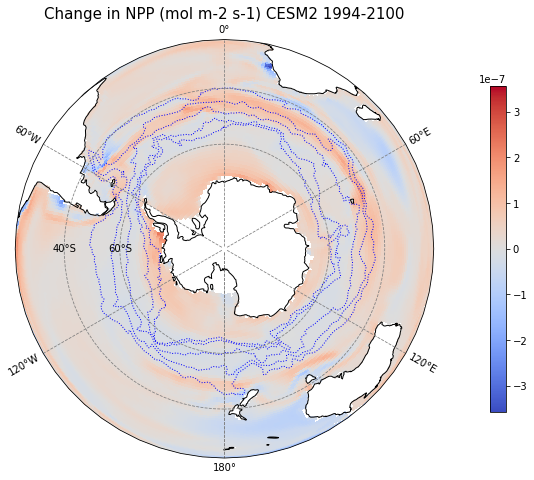

In [86]:
fig = plt.figure(figsize=[10, 10])

ax = fig.add_subplot(1,1,1,
                     projection = cartopy.crs.Orthographic(central_longitude = 0, 
                                                  central_latitude=-90))
#ax = plt.axes(projection=cartopy.crs.PlateCarree())

plt.title("Change in NPP (mol m-2 s-1) {} 1994-2100".format(model, start),
         fontsize = 15)

#ax.add_feature(cartopy.feature.LAND)
#ax.add_feature(cartopy.feature.OCEAN)
#ax.add_feature(cartopy.feature.COASTLINE)



divnorm = colors.TwoSlopeNorm(vmin = -label, vcenter = 0., vmax = label)

p = ax.pcolor(x, y, var, 
              cmap = 'coolwarm', norm = divnorm, transform = cartopy.crs.PlateCarree() )

cb = plt.colorbar(p, shrink=0.6, pad = 0.1)



gl = ax.gridlines(crs = cartopy.crs.PlateCarree(),
                  draw_labels = True,
                  color = 'grey',
                  linestyle = '--',
                  y_inline = True) 

gl.ylabel_style = {'size': 10}
gl.xlabel_style = {'size': 10}

gl.ylocator = mticker.FixedLocator([-60, -40])

plt.draw()
for ea in gl.label_artists:
    if ea[0]== 'lat':
        tx = ea[2]
        xy = tx.get_position()
        if xy[0]!=-90:
            tx.set_position([-90, xy[1]])
            

            
ax.coastlines()


ax.add_geometries(shape['geometry'], 
                  cartopy.crs.PlateCarree(),
                  facecolor = 'none', 
                  edgecolor = 'blue',
                  linestyle = ':')



#ax.contour(x_coord, y_coord, z,
         #  levels=1,
          # colors=['black'],
          # transform = cartopy.crs.PlateCarree())

            
            
plt.savefig("output/{}_{}_{}_change.png".format(variable, model, experiment))

plt.show()

/home/jasmine/anaconda3/envs/cdo_stable/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
/home/jasmine/anaconda3/envs/cdo_stable/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/jasmine/anaconda3/envs/cdo_stable/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
/home/jasmine/anaconda3/envs/cdo_stable/lib/python3.9/site-packages/cartopy/crs.py:385: ShapelyDeprecationWarni

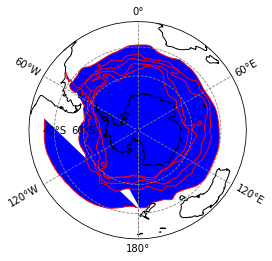

In [21]:
ax = plt.axes(projection=cartopy.crs.Orthographic(central_longitude = 0, 
                                                  central_latitude=-90))


gl = ax.gridlines(crs = cartopy.crs.PlateCarree(),
                  draw_labels = True,
                  color = 'grey',
                  linestyle = '--',
                  y_inline = True) 

gl.ylocator = mticker.FixedLocator([-60, -40])


plt.draw()
for ea in gl.label_artists:
    if ea[0]== 'lat':
        tx = ea[2]
        xy = tx.get_position()
        if xy[0]!=-90:
            tx.set_position([-90, xy[1]])
            
ax.add_geometries(shape['geometry'], 
                  cartopy.crs.PlateCarree(),
                  facecolor = 'blue', 
                  edgecolor = 'red',
                  linestyle = '-')

ax.coastlines()
#plt.savefig("output/{}_{}_{}_change.png".format(variable, model, experiment))

#plt.show()


## Plotting map

### Max/min value for plotting 

### Max/min value for plotting 

In [30]:
file = "Data/{}_{}_{}.nc".format(variable, model, experiment)
nc = Dataset(file)

var = nc.variables [variable][:]
max_var = np.amax(var)
min_var = np.amin(var)

print(max_var)
print(min_var)

3.774536e-06
0.0


### 2015

In [7]:
data = nct.open_data("Data/{}_{}_{}.nc".format(variable, model, experiment))
data.select(year = start)
data.tmean()
data.to_nc("Data/{}_{}_{}_{}.nc".format(variable, model, experiment, start), overwrite = True)

In [8]:
file = "Data/{}_{}_{}_{}.nc".format(variable, model, experiment, start)
nc = Dataset(file)
print(nc.variables)

{'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    bounds: time_bnds
    units: days since 0001-01-01 00:00:00
    calendar: 365_day
    axis: T
unlimited dimensions: time
current shape = (1,)
filling off, 'time_bnds': <class 'netCDF4._netCDF4.Variable'>
float64 time_bnds(time, bnds)
unlimited dimensions: time
current shape = (1, 2)
filling off, 'lon': <class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (361,)
filling off, 'lat': <class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    standard_name: latitude
    long_name: Latitude
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (181,)
filling off, 'intpp': <class 'netCDF4._netCDF4.Variable'>
float32 intpp(time, lat, lon)
    standard_name: net_primary_mole_productivity_of_biomass_expressed_as_carbon_by_phytoplankton
    long_name: Primary

In [9]:
lat = nc.variables['lat'][:] # [:] means all elements inside the list
lon = nc.variables['lon'][:]
var = nc.variables [variable][:]

mean_var = np.nanmean(var, axis = 0) 
print(mean_var.shape) 

x, y = np.meshgrid(lon, lat)

(181, 361)


shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


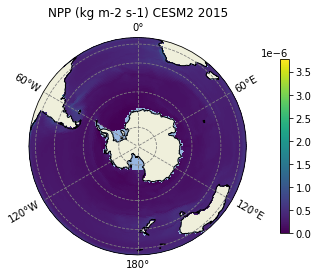

In [10]:
ax = plt.axes(projection=cartopy.crs.Orthographic(central_longitude = 0, 
                                                  central_latitude=-90))

plt.title("NPP (mol m-2 s-1) {} {}".format(model, start))
    
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)


p = ax.pcolor(x, y, mean_var, vmax = max_var, vmin = min_var, 
              transform = cartopy.crs.PlateCarree() )

cb = plt.colorbar(p, shrink=0.8, pad = 0.1)

gl = ax.gridlines(crs = cartopy.crs.PlateCarree(),
                  draw_labels = True,
                  color = 'grey',
                  linestyle = '--') 


plt.savefig("output/{}_{}_{}_{}.png".format(variable, model, experiment, start))

plt.show()


### 2100

In [11]:
data = nct.open_data("Data/{}_{}_{}.nc".format(variable, model, experiment))
data.select(year = end)
data.tmean()
data.to_nc("Data/{}_{}_{}_{}.nc".format(variable, model, experiment, end), overwrite = True)

In [12]:
file = "Data/{}_{}_{}_{}.nc".format(variable, model, experiment, end)
nc = Dataset(file)
print(nc.variables)

{'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    bounds: time_bnds
    units: days since 0001-01-01 00:00:00
    calendar: 365_day
    axis: T
unlimited dimensions: time
current shape = (1,)
filling off, 'time_bnds': <class 'netCDF4._netCDF4.Variable'>
float64 time_bnds(time, bnds)
unlimited dimensions: time
current shape = (1, 2)
filling off, 'lon': <class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (361,)
filling off, 'lat': <class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    standard_name: latitude
    long_name: Latitude
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (181,)
filling off, 'intpp': <class 'netCDF4._netCDF4.Variable'>
float32 intpp(time, lat, lon)
    standard_name: net_primary_mole_productivity_of_biomass_expressed_as_carbon_by_phytoplankton
    long_name: Primary

In [13]:
lat = nc.variables['lat'][:] # [:] means all elements inside the list
lon = nc.variables['lon'][:]
var = nc.variables [variable][:]

mean_var = np.nanmean(var, axis = 0) 
print(mean_var.shape) 

x, y = np.meshgrid(lon, lat)

(181, 361)


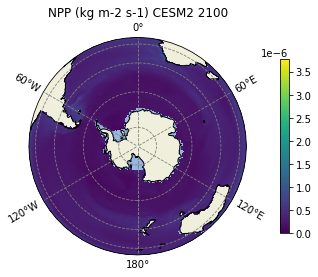

In [14]:
ax = plt.axes(projection=cartopy.crs.Orthographic(central_longitude = 0, 
                                                  central_latitude=-90))

plt.title("NPP (mol m-2 s-1) {} {}".format(model, end))
    
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)


p = ax.pcolor(x, y, mean_var, vmax = max_var, vmin = min_var, 
              transform = cartopy.crs.PlateCarree() )

cb = plt.colorbar(p, shrink=0.8, pad = 0.1)

gl = ax.gridlines(crs = cartopy.crs.PlateCarree(),
                  draw_labels = True,
                  color = 'grey',
                  linestyle = '--') 


plt.savefig("output/{}_{}_{}_{}.png".format(variable, model, experiment, end))

plt.show()


## Time series

In [15]:
# Join the two files with time 

data = nct.open_data("Data/{}_{}_{}.nc".format(variable, model, experiment))

time = data.years
time = tuple(time)
len(time)

86

In [16]:
# Select regions 40S south 

data.crop(lon = [-180, 180], lat = [-90, -40])

data.assign(space = lambda x: spatial_mean(x.intpp), drop = True)
data.rename({"space":"{}".format(variable)})
print(data.variables_detailed)

data.to_nc("Data/{}_{}_{}_40S.nc".format(variable, model, experiment), overwrite = True)

  variable  levels  points                                          long_name  \
0    intpp       1   65341  Primary Organic Carbon Production by All Types...   

         units  
0  mol m-2 s-1  


In [17]:
!cdo -yearmean Data/{variable}_{model}_{experiment}_40S.nc Data/{variable}_{model}_{experiment}_40S_mean.nc

cdo    yearmean: Processed 1 variable over 1117 timesteps [0.17s 220MB].


In [18]:
# Load new file: 
nc = Dataset("Data/{}_{}_{}_40S_mean.nc".format(variable, model, experiment))
print(nc.variables)
var_mean = nc.variables[variable][:]
print(var_mean.shape)
time_mean= nc.variables['time'][:]

{'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    bounds: time_bnds
    units: days since 0001-01-01 00:00:00
    calendar: 365_day
    axis: T
unlimited dimensions: time
current shape = (86,)
filling off, 'time_bnds': <class 'netCDF4._netCDF4.Variable'>
float64 time_bnds(time, bnds)
unlimited dimensions: time
current shape = (86, 2)
filling off, 'intpp': <class 'netCDF4._netCDF4.Variable'>
float32 intpp(time)
    _FillValue: 1e+20
    missing_value: 1e+20
    cell_methods: time: mean
unlimited dimensions: time
current shape = (86,)
filling off}
(86,)


In [19]:
!cdo -yearmax Data/{variable}_{model}_{experiment}_40S.nc Data/{variable}_{model}_{experiment}_40S_max.nc
!cdo -yearmin Data/{variable}_{model}_{experiment}_40S.nc Data/{variable}_{model}_{experiment}_40S_min.nc

cdo    yearmax: Processed 1 variable over 1117 timesteps [0.14s 220MB].
cdo    yearmin: Processed 1 variable over 1117 timesteps [0.15s 220MB].


In [20]:
# Load new file: 
nc = Dataset("Data/{}_{}_{}_40S_min.nc".format(variable, model, experiment))
             
var_min = nc.variables[variable][:]
time_min= nc.variables['time'][:]

print(var_min.shape)

(86,)


In [21]:
# Load new file: 
nc = Dataset("Data/{}_{}_{}_40S_max.nc".format(variable, model, experiment))
             
var_max = nc.variables[variable][:]
time_max= nc.variables['time'][:]

print(var_max.shape)

(86,)


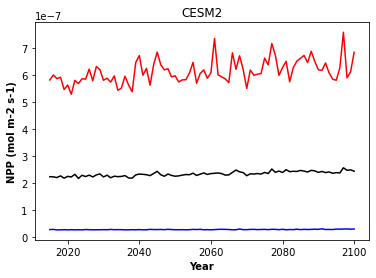

In [24]:
fig, ax = plt.subplots()

ax.plot(time, var_mean, 'k')
ax.plot(time, var_max, 'r')
ax.plot(time, var_min, 'b')

ax.title.set_text("{}".format(model))

ax.set_xlabel('xlabel', fontdict=dict(weight='bold'))
ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("NPP (mol m-2 s-1)")
plt.xlabel("Year")

plt.savefig("output/{}_{}_{}_projection.png".format(variable, model, experiment))

plt.show()